In [2]:
# import necessary packages and libraries 
import geopandas as gpd 
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np  # Corrected this line
import xarray as xr
import numpy as np
import os 
from datetime import datetime

In [3]:
# --- Configuration ---

# New ratio to convert GLDAS data from kg/m^2 to cm
KG_M2_TO_CM_RATIO = 0.1

# Input the file path to your main data directory
# Using r'' is a safer way to write Windows paths
BASE_DIR = r'D:\Groundwater Vulnerability Mapping\data'

# Default figure size for plots
FIG_SIZE = (10, 10)

In [4]:
# Common functions

def add_labels(ax, title):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title);

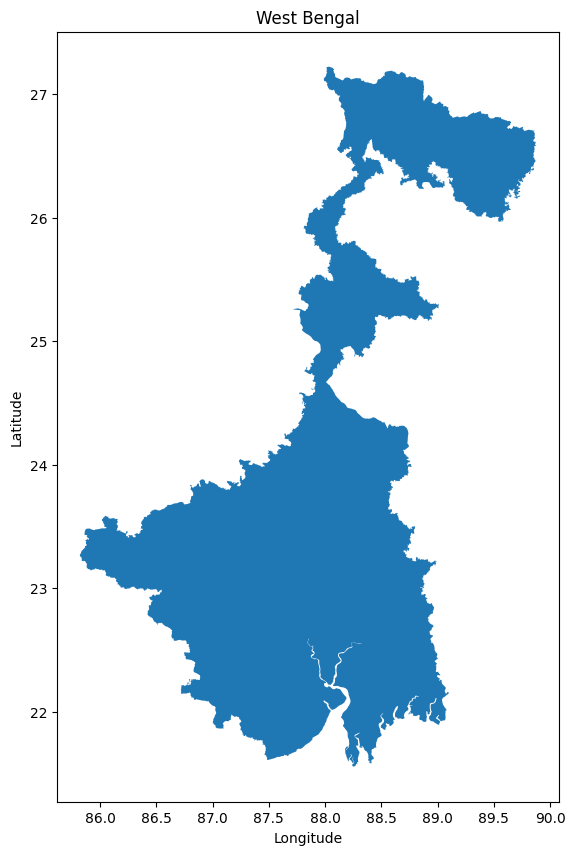

In [5]:
# Read the shapefile
basin_shapefile = gpd.read_file(os.path.join(BASE_DIR, r'shapefiles\West Bengal\West_Bengal.shp'))

# Reproject to standard latitude-longitude (WGS84)
basin_shapefile = basin_shapefile.to_crs(epsg=4326)

# Plot of entire West Bengal
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
add_labels(ax, 'West Bengal')

Longitude min: 85.81970749436145
Latitude min: 21.556115085291218
Longitude max: 89.87425124571746
Latitude max: 27.221013671249814


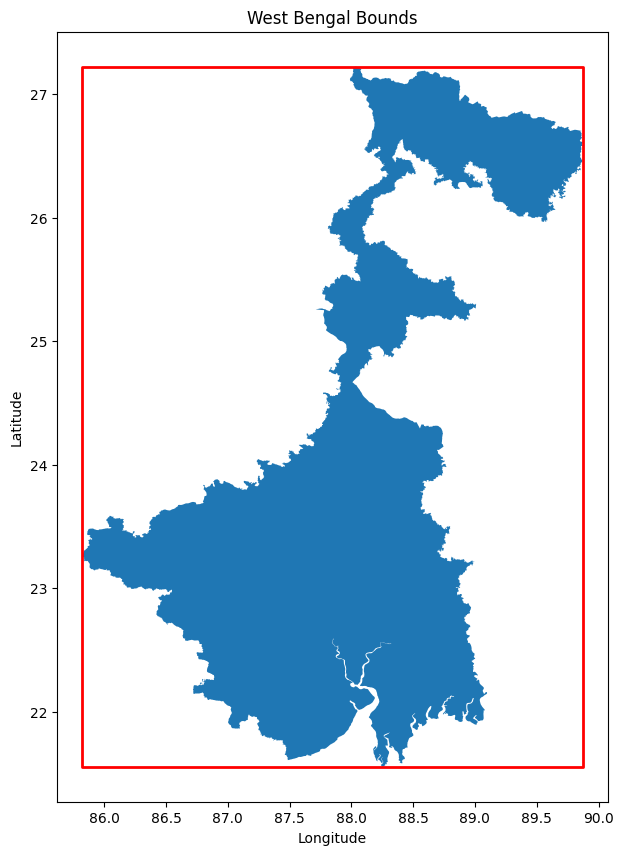

In [6]:
# Here, we use geopandas.GeoSeries.total_bounds
[lon_min, lat_min, lon_max, lat_max] = basin_shapefile.total_bounds

# Here, we visualize the bounding box
# First, we create a GeoDataFrame with a single rectangle geometry
bounding_box = gpd.GeoDataFrame(geometry=[box(lon_min, lat_min, lon_max, lat_max)])
# Then, we plot both the basin shapefile and the bounding_box
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
bounding_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

add_labels(ax, 'West Bengal Bounds')
print(f"Longitude min: {lon_min}")
print(f"Latitude min: {lat_min}")
print(f"Longitude max: {lon_max}")
print(f"Latitude max: {lat_max}")

In [7]:
# Here, we load in GRACE data.
grace = xr.open_dataset(os.path.join(BASE_DIR, r"RAW Data\GRACE\GRCTellus.JPL.200204_202505.GLO.RL06.3M.MSCNv04CRI.nc"))

# print out grace data. Our varibale of interest (lwe_thickness) is measured in centimeters 
grace

<xarray.Dataset> Size: 2GB
Dimensions:        (lon: 720, lat: 360, time: 245, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2025-05-...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 508MB ...
    uncertainty    (time, lat, lon) float64 508MB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
    land_mask      (lat, lon) float64 2MB ...
    scale_factor   (lat, lon) float64 2MB ...
    mascon_ID      (lat, lon) float64 2MB ...
    GAD            (time, lat, lon) float64 508MB ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.3Mv04 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2025-07-09T14:07:30Z

In [8]:
# A function that converts longitude from 0-360 to -180-180
def convert_longitude(lon):
    if lon >= 180:
        return lon - 360
    else:
        return lon
    

In [9]:
# Subset GRACE data to WB region BEFORE converting to DataFrame
grace = grace.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
# Only extracting the variables we need from the grace dataset, after which we convert everything into a dataframe.
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
# Expanding the entries (i.e., every lon lat combo has multiple times, thicknesses, and uncertainties, which we would like to be unique rows)
grace_df.reset_index(inplace=True)
# Relabel the columns to include units
grace_df = grace_df.rename(columns={'lwe_thickness': 'lwe_thickness_cm', 'uncertainty': 'uncertainty_cm'})
# Convert longitude values
grace_df['lon'] = grace_df['lon'].apply(convert_longitude)
# How many duplicates exist?
"There are %s duplicate rows" % grace_df.duplicated().sum()
# Next, we subset the data to only include pixels within the bounding rectangle
grace_df = grace_df[(grace_df.lon > lon_min) & (grace_df.lon < lon_max) & (grace_df.lat > lat_min) & (grace_df.lat < lat_max)]
# Finally, we sort using the time column
grace_df.sort_values(by='time', inplace=True)

In [10]:
import geopandas as gpd

print("Starting precise clip for GRACE data...")

# --- Step 1: Convert your grace_df into a GeoDataFrame ---
grace_gdf = gpd.GeoDataFrame(
    grace_df,
    crs='epsg:4326',
    geometry=gpd.points_from_xy(grace_df['lon'], grace_df['lat'])
)

# --- Step 2: Ensure basin shapefile is ready ---
basin_shapefile = basin_shapefile.to_crs('epsg:4326')

# --- Step 3: Perform the spatial join (the "clip") ---
grace_clipped_df = gpd.sjoin(grace_gdf, basin_shapefile, how="inner", predicate="intersects")

# --- Step 4: THE FIX - Clean up and select the CORRECT final columns ---
# We only keep the columns that exist in our new cm-based workflow.
final_grace_columns = [
    'time', 
    'lat', 
    'lon', 
    'lwe_thickness_cm', 
    'uncertainty_cm', 
    'scale_factor'
]
grace_final_df = grace_clipped_df[final_grace_columns]

# --- Step 5: Save the final processed file ---
grace_output_filename = 'grace_processed_clipped_cm.csv' #<-- Changed name for clarity
grace_final_df.to_csv(grace_output_filename, index=False)

print(f"\n✅ SUCCESS: The file '{grace_output_filename}' has been created.")
print("\n--- Preview of the final, clipped GRACE data (in cm) ---")
print(grace_final_df.head())

Starting precise clip for GRACE data...

✅ SUCCESS: The file 'grace_processed_clipped_cm.csv' has been created.

--- Preview of the final, clipped GRACE data (in cm) ---
                     time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
735   2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
8820  2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
9065  2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
9310  2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
18620 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

       scale_factor  
735        0.967227  
8820       1.054784  
9065       1.054784  
9310       0.955446  
18620      1.280962  


In [11]:
# Read in one file of the GLDAS data as a demonstration
# Note the interested variables "SWE_inst" and "RootMoist_inst" are measured in kilogram per square meter (kg/m2)

xr.open_dataset(r"D:\Groundwater Vulnerability Mapping\data\RAW Data\GLDAS_NOAH025_M_2.1-20250814_151559\GLDAS_NOAH025_M.A200001.021.nc4")

<xarray.Dataset> Size: 124MB
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 8B 2000-01-01
  * lon                    (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                    (lat) float32 2kB -59.88 -59.62 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] 16B ...
    Swnet_tavg             (time, lat, lon) float32 3MB ...
    Lwnet_tavg             (time, lat, lon) float32 3MB ...
    Qle_tavg               (time, lat, lon) float32 3MB ...
    Qh_tavg                (time, lat, lon) float32 3MB ...
    Qg_tavg                (time, lat, lon) float32 3MB ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 3MB ...
    Tair_f_inst            (time, lat, lon) float32 3MB ...
    Qair_f_inst            (time, lat, lon) float32 3MB ...
    Psurf_f_inst           (time, lat, lon) float32 3MB ...
    SWdown_f_tavg          (time, lat, lon) float32 3MB ...
    LWdown_f_tavg          (time, lat, lon) float32 3MB ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-17T14:58:21.836
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [12]:
import pandas as pd
import xarray as xr
import os

# Define the path to your GLDAS files
gldas_path = r"D:\Groundwater Vulnerability Mapping\data\RAW Data\GLDAS_NOAH025_M_2.1-20250814_151559"

# Create an empty DataFrame to store the combined data
gldas_df = pd.DataFrame()

# Define the list of soil moisture layers to sum
soil_layers = [
    'SoilMoi0_10cm_inst', 
    'SoilMoi10_40cm_inst', 
    'SoilMoi40_100cm_inst', 
    'SoilMoi100_200cm_inst'
]

print("Starting memory-efficient GLDAS data processing...")
# Iterate through each file in the directory
for filename in os.listdir(gldas_path):
    
    if filename.endswith(".nc4"):
        
        file_path = os.path.join(gldas_path, filename)
        
        # 1. Reading in data as xarray
        xd = xr.open_dataset(file_path)

        # 2. Filter the xarray object FIRST (this is memory-efficient)
        xd_subset = xd.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

        # 3. Convert only the SMALL SUBSET to a DataFrame
        xd_df = xd_subset.to_dataframe()
        xd_df.reset_index(inplace=True)

        # 4. Perform your calculations on the small DataFrame
        xd_df['SoilMoi0_200cm_inst'] = xd_df[soil_layers].sum(axis=1)

        # Extract only the columns you need
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", "Qs_acc", "SoilMoi0_200cm_inst"]]
        df_slice = df_slice.drop_duplicates()

        # Append the data for this month to the main DataFrame
        gldas_df = pd.concat([gldas_df, df_slice], axis=0)

# Rename the columns to include units for clarity
gldas_df = gldas_df.rename(columns={
    'SWE_inst': 'SWE_inst_kg/m2',
    'Qs_acc': 'Qs_acc_kg/m2',
    'SoilMoi0_200cm_inst': 'TotalSoilMoisture_kg/m2'
})

print("\n✅ GLDAS data processing complete.")
print("\n--- Preview of the Final GLDAS Data ---")
print(gldas_df.head())

Starting memory-efficient GLDAS data processing...

✅ GLDAS data processing complete.

--- Preview of the Final GLDAS Data ---
        time     lon     lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  85.875  21.625             0.0      0.000005   
1 2000-01-01  85.875  21.875             0.0      0.000012   
2 2000-01-01  85.875  22.125             0.0      0.000021   
3 2000-01-01  85.875  22.375             0.0      0.000177   
4 2000-01-01  85.875  22.625             0.0      0.000230   

   TotalSoilMoisture_kg/m2  
0               402.055817  
1               411.130768  
2               415.805115  
3               629.142212  
4               634.998657  


In [13]:
# --- Step 1: Define the correct conversion ratio ---
# Kilograms per square meter to Centimeters
KG_M2_TO_CM_RATIO = 0.1 

# --- Step 2: Convert Units from kg/m^2 to cm ---
print("Converting all GLDAS variables to depth (cm)...")

# Apply the conversion to your Total Soil Moisture column
gldas_df['TotalSoilMoisture_cm'] = gldas_df['TotalSoilMoisture_kg/m2'] * KG_M2_TO_CM_RATIO

# Apply the conversion to your Snow Water Equivalent column
gldas_df['SWE_cm'] = gldas_df['SWE_inst_kg/m2'] * KG_M2_TO_CM_RATIO

# Apply the conversion to your Runoff column
gldas_df['Qs_acc_cm'] = gldas_df['Qs_acc_kg/m2'] * KG_M2_TO_CM_RATIO

print("\n✅ Unit conversion to cm complete.")
print("\n--- Preview of Data with Centimeter Columns ---")

# Display only the key columns for a clean preview
print(gldas_df.head())

Converting all GLDAS variables to depth (cm)...

✅ Unit conversion to cm complete.

--- Preview of Data with Centimeter Columns ---
        time     lon     lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  85.875  21.625             0.0      0.000005   
1 2000-01-01  85.875  21.875             0.0      0.000012   
2 2000-01-01  85.875  22.125             0.0      0.000021   
3 2000-01-01  85.875  22.375             0.0      0.000177   
4 2000-01-01  85.875  22.625             0.0      0.000230   

   TotalSoilMoisture_kg/m2  TotalSoilMoisture_cm  SWE_cm     Qs_acc_cm  
0               402.055817             40.205582     0.0  4.717742e-07  
1               411.130768             41.113079     0.0  1.153226e-06  
2               415.805115             41.580513     0.0  2.112903e-06  
3               629.142212             62.914223     0.0  1.770161e-05  
4               634.998657             63.499866     0.0  2.297581e-05  


In [14]:
import geopandas as gpd

print("Starting precise clip for GLDAS data...")

# --- Step 1: Convert your gldas_df into a GeoDataFrame ---
gldas_gdf = gpd.GeoDataFrame(
    gldas_df,
    crs='epsg:4326',  
    geometry=gpd.points_from_xy(gldas_df['lon'], gldas_df['lat'])
)

# --- Step 2: Perform the spatial join (the "clip") ---
# Get the list of original columns BEFORE the join
original_gldas_columns = gldas_gdf.columns.tolist()

# Perform the join
gldas_clipped_df = gpd.sjoin(gldas_gdf, basin_shapefile, how="inner", predicate="intersects")

# --- Step 3: Clean up the final DataFrame ---
# Select ONLY the original columns to remove the extra ones from the shapefile
gldas_final_df = gldas_clipped_df[original_gldas_columns]

print("\n✅ GLDAS data has been successfully clipped to the basin.")
print("\n--- Preview of the final, clipped GLDAS data (with all columns) ---")
print(gldas_final_df.head())

Starting precise clip for GLDAS data...

✅ GLDAS data has been successfully clipped to the basin.

--- Preview of the final, clipped GLDAS data (with all columns) ---
         time     lon     lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
7  2000-01-01  85.875  23.375             0.0      0.000048   
29 2000-01-01  86.125  23.125             0.0      0.000061   
30 2000-01-01  86.125  23.375             0.0      0.000035   
52 2000-01-01  86.375  23.125             0.0      0.000043   
53 2000-01-01  86.375  23.375             0.0      0.000044   

    TotalSoilMoisture_kg/m2  TotalSoilMoisture_cm  SWE_cm  Qs_acc_cm  \
7                450.469360             45.046936     0.0   0.000005   
29               458.309387             45.830940     0.0   0.000006   
30               419.461182             41.946117     0.0   0.000004   
52               421.693817             42.169384     0.0   0.000004   
53               433.443512             43.344353     0.0   0.000004   

                 geom

In [15]:
# Define a name for your output file
output_filename = 'gldas_NOAH_cm_clipped_high_resolution.csv'

# Save the gldas_final_df DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
gldas_final_df.to_csv(output_filename, index=False)

print(f"✅ Successfully saved the clipped high-resolution GLDAS data to '{output_filename}'")

✅ Successfully saved the clipped high-resolution GLDAS data to 'gldas_NOAH_cm_clipped_high_resolution.csv'


In [16]:
import pandas as pd
import xarray as xr

# --- Step 1: Load your high-resolution clipped data ---
high_res_filename = 'gldas_NOAH_cm_clipped_high_resolution.csv'
gldas_final_df = pd.read_csv(high_res_filename)
gldas_final_df['time'] = pd.to_datetime(gldas_final_df['time'])

# --- Step 2: Convert DataFrame to an xarray Dataset ---
print("Converting data to a grid format...")
gldas_xr = gldas_final_df.set_index(['time', 'lat', 'lon']).to_xarray()

# --- Step 3: Coarsen the grid from 0.25° to 0.5° ---
print("Downscaling data from 0.25° to 0.5° resolution...")

# THE FIX: Define two lists of variables for the two different methods
sum_variables = ['TotalSoilMoisture_kg/m2', 'SWE_inst_kg/m2', 'Qs_acc_kg/m2']
mean_variables = ['TotalSoilMoisture_cm', 'SWE_cm', 'Qs_acc_cm']

coarsening_factor = 2

# Coarsen the mass-based variables using .sum()
gldas_sum_xr = gldas_xr[sum_variables].coarsen(
    lon=coarsening_factor, 
    lat=coarsening_factor, 
    boundary='trim'
).sum()

# Coarsen the depth-based variables using .mean()
gldas_mean_xr = gldas_xr[mean_variables].coarsen(
    lon=coarsening_factor, 
    lat=coarsening_factor, 
    boundary='trim'
).mean()

# Merge the two results back together
gldas_downscaled_xr = xr.merge([gldas_sum_xr, gldas_mean_xr])

# --- Step 4: Convert the downscaled data back to a DataFrame ---
gldas_downscaled_df = gldas_downscaled_xr.to_dataframe().reset_index()

print("\n✅ Downscaling complete and scientifically correct.")
print("\n--- Preview of the Final, Downscaled GLDAS Data ---")
print(gldas_downscaled_df.head())

Converting data to a grid format...
Downscaling data from 0.25° to 0.5° resolution...

✅ Downscaling complete and scientifically correct.

--- Preview of the Final, Downscaled GLDAS Data ---
        time   lat   lon  TotalSoilMoisture_kg/m2  SWE_inst_kg/m2  \
0 2000-01-01  22.0  86.0                  0.00000             0.0   
1 2000-01-01  22.0  86.5                  0.00000             0.0   
2 2000-01-01  22.0  87.0                925.74454             0.0   
3 2000-01-01  22.0  87.5               2121.57678             0.0   
4 2000-01-01  22.0  88.0               2104.78141             0.0   

   Qs_acc_kg/m2  TotalSoilMoisture_cm  SWE_cm  Qs_acc_cm  
0      0.000000                   NaN     NaN        NaN  
1      0.000000                   NaN     NaN        NaN  
2      0.000069             46.287228     0.0   0.000003  
3      0.000264             53.039421     0.0   0.000007  
4      0.000753             70.159383     0.0   0.000025  


In [17]:
# Define a name for your final, downscaled GLDAS file
output_filename = 'gldas_NOAH_cm_final_downscaled0.5.csv'

# Save the gldas_downscaled_df DataFrame to a CSV file
gldas_downscaled_df.to_csv(output_filename, index=False)

print(f"✅ Successfully saved the final downscaled GLDAS data to '{output_filename}'")

✅ Successfully saved the final downscaled GLDAS data to 'gldas_NOAH_cm_final_downscaled0.5.csv'


In [18]:
import pandas as pd
import xarray as xr

# --- Step 1: Load both of your final processed datasets ---
print("Loading processed GRACE and GLDAS data...")

# THE FIX: Load the correct cm-based GRACE file
grace_df = pd.read_csv('grace_processed_clipped_cm.csv') 
gldas_df = pd.read_csv('gldas_NOAH_cm_final_downscaled0.5.csv')

# Ensure time columns are in datetime format
grace_df['time'] = pd.to_datetime(grace_df['time'])
gldas_df['time'] = pd.to_datetime(gldas_df['time'])

# --- Step 2: Align the coordinate grids using xarray ---
print("Aligning coordinate grids for a perfect merge...")

# Convert both DataFrames to xarray Datasets
grace_xr = grace_df.set_index(['time', 'lat', 'lon']).to_xarray()
gldas_xr = gldas_df.set_index(['time', 'lat', 'lon']).to_xarray()

# Reindex the GLDAS data to match the GRACE coordinates exactly
gldas_aligned_xr = gldas_xr.reindex_like(grace_xr, method='nearest')

# --- Step 3: Merge the aligned data ---
# Convert the aligned GLDAS data back to a DataFrame
gldas_aligned_df = gldas_aligned_xr.to_dataframe().reset_index()

# Now, merge the original GRACE df with the ALIGNED GLDAS df
print("Merging aligned datasets...")
final_merged_df = pd.merge(
    grace_df,
    gldas_aligned_df,
    on=['time', 'lat', 'lon'],
    how='left'
)

# THE FIX: The lines for dropping/renaming surface_area_km2 have been removed.

# --- Step 4: Save the final master file ---
final_output_filename = 'grace_gldas_NOAH_final_merged_cm.csv' #<-- Renamed for clarity
final_merged_df.to_csv(final_output_filename, index=False)

print("\n✅ All data processing is complete!")
print(f"Your final, merged master file has been saved as '{final_output_filename}'")
print("\n--- Preview of the Final Merged Data ---")
print(final_merged_df.head())

Loading processed GRACE and GLDAS data...
Aligning coordinate grids for a perfect merge...
Merging aligned datasets...

✅ All data processing is complete!
Your final, merged master file has been saved as 'grace_gldas_NOAH_final_merged_cm.csv'

--- Preview of the Final Merged Data ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  TotalSoilMoisture_kg/m2  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0      0.967227               1302.16327             0.0      0.012060   
1      1.054784               1932.38083             0.0      0.062506   
2      1.054784               1953.10294             0

In [19]:
# --- Step 0: Clean up columns from any previous runs ---
cols_to_check = [
    'TotalSoilMoisture_mean_cm', 'SWE_mean_cm', 'Qs_acc_mean_cm',
    'TotalSoilMoisture_anomaly_cm', 'SWE_anomaly_cm', 'Qs_acc_anomaly_cm'
]
# THE FIX: Use the 'final_merged_df' from the previous step as the input
input_df = final_merged_df.copy()

cols_to_drop = [col for col in cols_to_check if col in input_df.columns]
if cols_to_drop:
    print(f"Removing old calculation columns: {cols_to_drop}")
    input_df = input_df.drop(columns=cols_to_drop)


# --- Step 1: Calculate the long-term mean for each grid cell (in cm) ---
print("Calculating the long-term mean for each grid cell (in cm)...")
# Using the original calculation method as requested
average_df = input_df.groupby(['lat','lon']).agg({
    'TotalSoilMoisture_cm': 'mean',
    'SWE_cm': 'mean',
    'Qs_acc_cm': 'mean'
}).reset_index()

average_df = average_df.rename(columns={
    'TotalSoilMoisture_cm': 'TotalSoilMoisture_mean_cm',
    'SWE_cm': 'SWE_mean_cm',
    'Qs_acc_cm': 'Qs_acc_mean_cm'
})


# --- Step 2: Merge the calculated means back onto the main DataFrame ---
final_df = input_df.merge(average_df, on=['lat','lon'], how='left')


# --- Step 3: Compute the anomaly for each variable ---
print("Calculating anomalies (in cm)...")
final_df['TotalSoilMoisture_anomaly_cm'] = final_df['TotalSoilMoisture_cm'] - final_df['TotalSoilMoisture_mean_cm']
final_df['SWE_anomaly_cm'] = final_df['SWE_cm'] - final_df['SWE_mean_cm']
final_df['Qs_acc_anomaly_cm'] = final_df['Qs_acc_cm'] - final_df['Qs_acc_mean_cm']


print("\n✅ Anomaly calculation complete.")
print("\n--- Preview of Data with Anomaly Columns ---")

# THE FIX: Use .head() to correctly display the DataFrame preview
print(final_df.head())

Calculating the long-term mean for each grid cell (in cm)...
Calculating anomalies (in cm)...

✅ Anomaly calculation complete.

--- Preview of Data with Anomaly Columns ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  TotalSoilMoisture_kg/m2  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0      0.967227               1302.16327             0.0      0.012060   
1      1.054784               1932.38083             0.0      0.062506   
2      1.054784               1953.10294             0.0      0.055250   
3      0.955446               1953.10294             0.0      0.055250   
4      1.280962   

In [20]:
# Define a name for your final, master file
# It's good practice to include the units in the filename for clarity
final_output_filename = 'grace_gldas_NOAH_anomalies_final_cm.csv'

# Save the final_df DataFrame to a CSV file
# THE FIX: Use the correct DataFrame name 'final_df'
final_df.to_csv(final_output_filename, index=False)

print(f"✅ All done! Your final, complete dataset has been saved to '{final_output_filename}'")

✅ All done! Your final, complete dataset has been saved to 'grace_gldas_NOAH_anomalies_final_cm.csv'


In [21]:
import pandas as pd

# --- Step 1: Load your final, anomaly-ready master file ---
# THE FIX: Load the correct cm-based file
final_df = pd.read_csv('grace_gldas_NOAH_anomalies_final_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Calculate Groundwater Storage (GWS) Anomaly in cm ---
# GWS Anomaly = TWS Anomaly - (Soil Moisture Anomaly + Snow Anomaly + Runoff Anomaly)
# NOTE: The GRACE lwe_thickness_cm is already an anomaly value.
final_df['GWS_anomaly_cm'] = final_df['lwe_thickness_cm'] - (
    final_df['TotalSoilMoisture_anomaly_cm'] + 
    final_df['SWE_anomaly_cm'] + 
    final_df['Qs_acc_anomaly_cm']
)

print("✅ Groundwater Anomaly (GWS) calculated for each grid cell in centimeters.")

# --- Step 3: Preview the final result ---
print("\n--- Preview of Final Data with GWS Anomaly (in cm) ---")

# Display the key columns used in the calculation and the final result
print(final_df[[
    'time',
    'lat',
    'lon',
    'lwe_thickness_cm',               # This is TWS Anomaly
    'TotalSoilMoisture_anomaly_cm',   # This is SMS Anomaly
    'SWE_anomaly_cm',                 # This is part of SWS Anomaly
    'Qs_acc_anomaly_cm',              # This is part of SWS Anomaly
    'GWS_anomaly_cm'                  # This is the final result
]].head())

✅ Groundwater Anomaly (GWS) calculated for each grid cell in centimeters.

--- Preview of Final Data with GWS Anomaly (in cm) ---
                 time    lat    lon  lwe_thickness_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763   

   TotalSoilMoisture_anomaly_cm  SWE_anomaly_cm  Qs_acc_anomaly_cm  \
0                     -4.490292    0.000000e+00          -0.001177   
1                     -6.909954    0.000000e+00          -0.001600   
2                     -5.038512    0.000000e+00          -0.001807   
3                     -5.038512    0.000000e+00          -0.001807   
4                      2.257867   -1.645820e-08          -0.008032   

   GWS_anomaly_cm  
0       -7.511963  
1       -5.091877  
2       -6.963112  
3       -6.963112  
4     

In [22]:
# Define a name for your final results file
final_gws_filename = 'NOAH_GWS_Final_Results_per_Pixel_cm.csv'

# Save the final_df which contains the GWS_anomaly_cm column
final_df.to_csv(final_gws_filename, index=False)

print(f"✅ Final results saved successfully to '{final_gws_filename}'")

✅ Final results saved successfully to 'NOAH_GWS_Final_Results_per_Pixel_cm.csv'


Generating the final time-series plot...


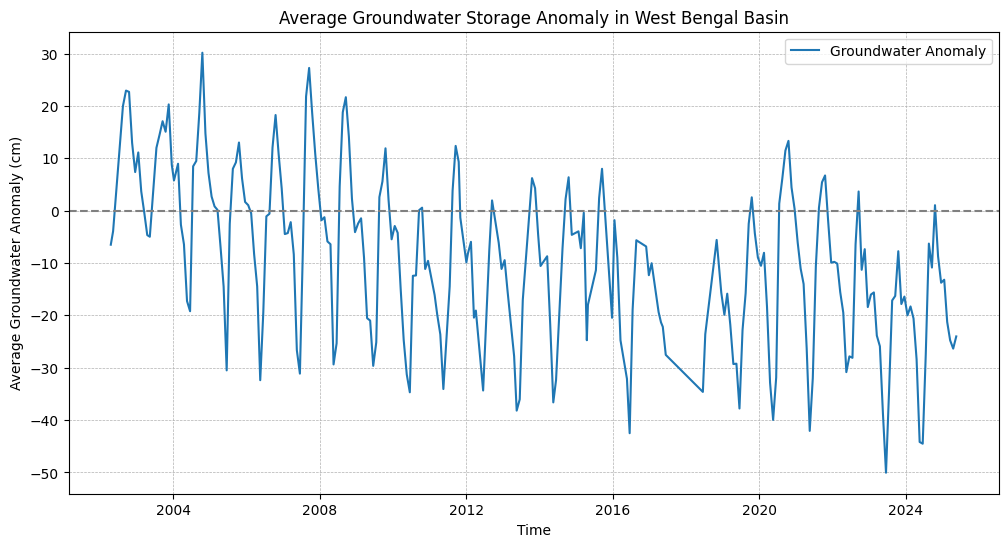

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your final file with the per-pixel GWS data (in cm) ---
# THE FIX: Load the correct cm-based file
final_df = pd.read_csv('NOAH_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Select the necessary columns ---
# THE FIX: Use the correct cm-based column name
gws_timeseries = final_df[['time', 'GWS_anomaly_cm']].copy()

# --- Step 3: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = gws_timeseries.groupby('time').mean().reset_index()

# --- Step 4: Create the plot ---
print("Generating the final time-series plot...")

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plotting the data
# THE FIX: Use the correct cm-based column name
plt.plot('time', 'GWS_anomaly_cm', data=gws_basin_avg, label='Groundwater Anomaly')

# Plotting a horizontal line at y=0 to serve as a baseline
plt.axhline(y=0, color='gray', linestyle='--')

# Adding a title and labels
plt.title('Average Groundwater Storage Anomaly in West Bengal Basin')
plt.xlabel('Time')
# THE FIX: Update the y-axis label to 'cm'
plt.ylabel('Average Groundwater Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Displaying the plot
plt.show()


Generating the final time-series plot with missing data markers...


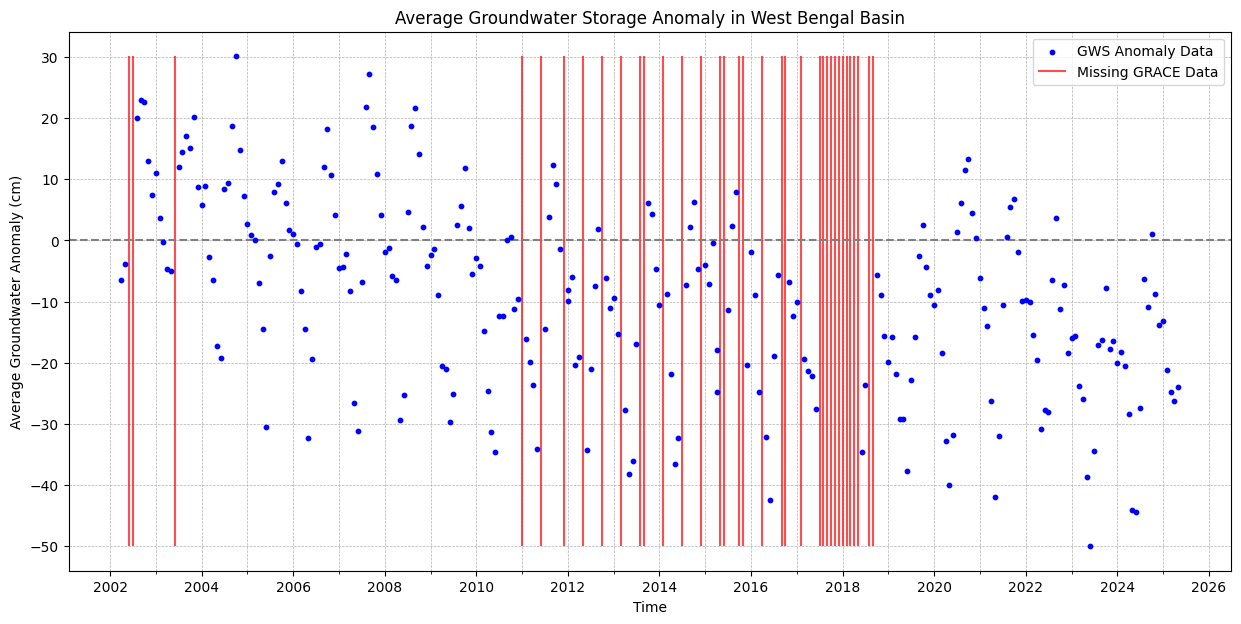

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Step 1: Load your final GWS results file ---
final_df = pd.read_csv('NOAH_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Aggregate to a basin-wide average time series ---
gws_basin_avg = final_df.groupby('time')['GWS_anomaly_cm'].mean().reset_index()

# --- THE FIX: Standardize the dates to the 1st of the month ---
# This ensures the dates in your data will match the full calendar
gws_basin_avg['time'] = gws_basin_avg['time'].dt.to_period('M').dt.start_time

# --- Step 3: Create a complete, continuous monthly date range ---
full_date_range = pd.date_range(
    start=gws_basin_avg['time'].min(), 
    end=gws_basin_avg['time'].max(), 
    freq='MS' # Month Start frequency
)
full_date_df = pd.DataFrame({'time': full_date_range})

# --- Step 4: Merge the gappy data with the full date range ---
plot_df = pd.merge(full_date_df, gws_basin_avg, on='time', how='left')

# Separate the data into two parts: one with values, one without
has_data = plot_df.dropna()
missing_data = plot_df[plot_df['GWS_anomaly_cm'].isna()]


# --- Step 5: Create the plot ---
print("Generating the final time-series plot with missing data markers...")

plt.figure(figsize=(15, 7))
ax = plt.gca()

# Plot the available data as blue dots
ax.scatter(has_data['time'], has_data['GWS_anomaly_cm'], color='blue', s=10, zorder=5, label='GWS Anomaly Data')

# Plot the missing data as red vertical lines
# We adjust ymin and ymax to be relative to the data range for better visuals
if not missing_data.empty:
    data_min = has_data['GWS_anomaly_cm'].min()
    data_max = has_data['GWS_anomaly_cm'].max()
    ax.vlines(missing_data['time'], ymin=data_min, ymax=data_max, color='red', linestyle='-', linewidth=1.5, alpha=0.7, label='Missing GRACE Data')

# Add a baseline and formatting
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_title('Average Groundwater Storage Anomaly in West Bengal Basin')
ax.set_xlabel('Time')
ax.set_ylabel('Average Groundwater Anomaly (cm)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Generating the final plot with a connected line AND missing data markers...


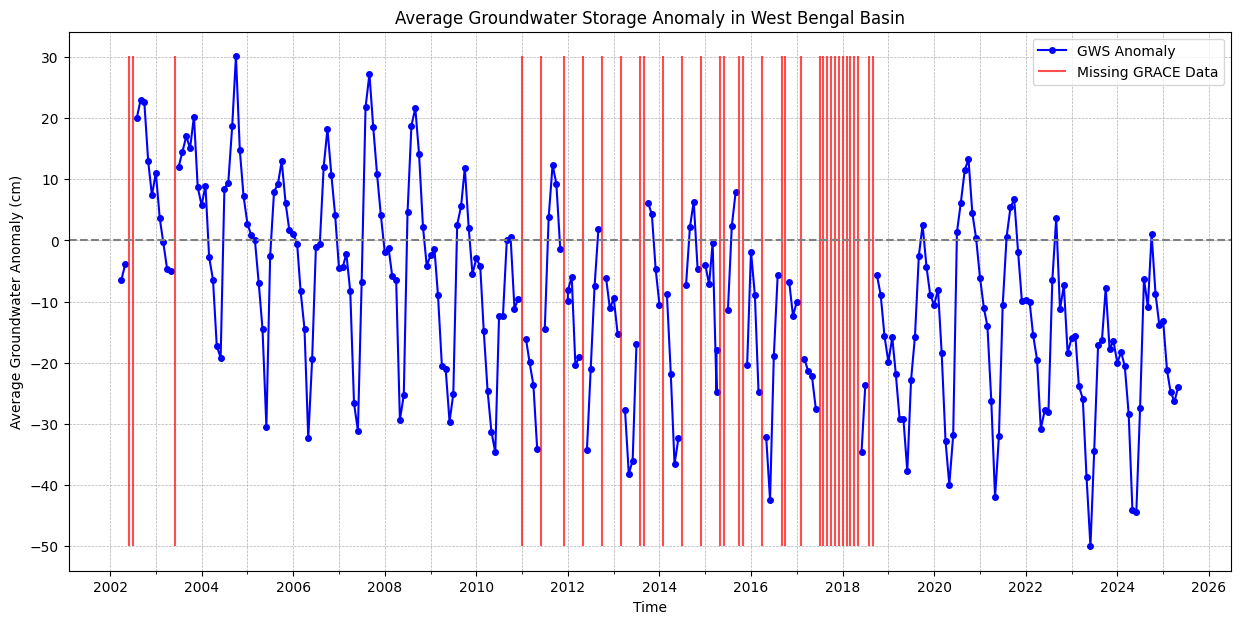

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Steps 1-4: Load and prepare the data (these are unchanged) ---
final_df = pd.read_csv('NOAH_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

gws_basin_avg = final_df.groupby('time')['GWS_anomaly_cm'].mean().reset_index()

gws_basin_avg['time'] = gws_basin_avg['time'].dt.to_period('M').dt.start_time

full_date_range = pd.date_range(
    start=gws_basin_avg['time'].min(),
    end=gws_basin_avg['time'].max(),
    freq='MS'
)
full_date_df = pd.DataFrame({'time': full_date_range})

plot_df = pd.merge(full_date_df, gws_basin_avg, on='time', how='left')


# --- Step 5: Create the combined plot ---
print("Generating the final plot with a connected line AND missing data markers...")

plt.figure(figsize=(15, 7))
ax = plt.gca()

# --- Plot the connected line for available data ---
ax.plot(
    plot_df['time'],
    plot_df['GWS_anomaly_cm'],
    color='blue',
    marker='o',
    linestyle='-',
    markersize=4,
    label='GWS Anomaly'
)

# --- Find and plot the missing data as red vertical lines ---
missing_data = plot_df[plot_df['GWS_anomaly_cm'].isna()]
if not missing_data.empty:
    data_min = plot_df['GWS_anomaly_cm'].min()
    data_max = plot_df['GWS_anomaly_cm'].max()
    ax.vlines(
        missing_data['time'],
        ymin=data_min,
        ymax=data_max,
        color='red',
        linestyle='-',
        linewidth=1.5,
        alpha=0.7,
        label='Missing GRACE Data'
    )

# Add a baseline and formatting
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_title('Average Groundwater Storage Anomaly in West Bengal Basin')
ax.set_xlabel('Time')
ax.set_ylabel('Average Groundwater Anomaly (cm)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Generating the final connected time-series plot with data gaps...


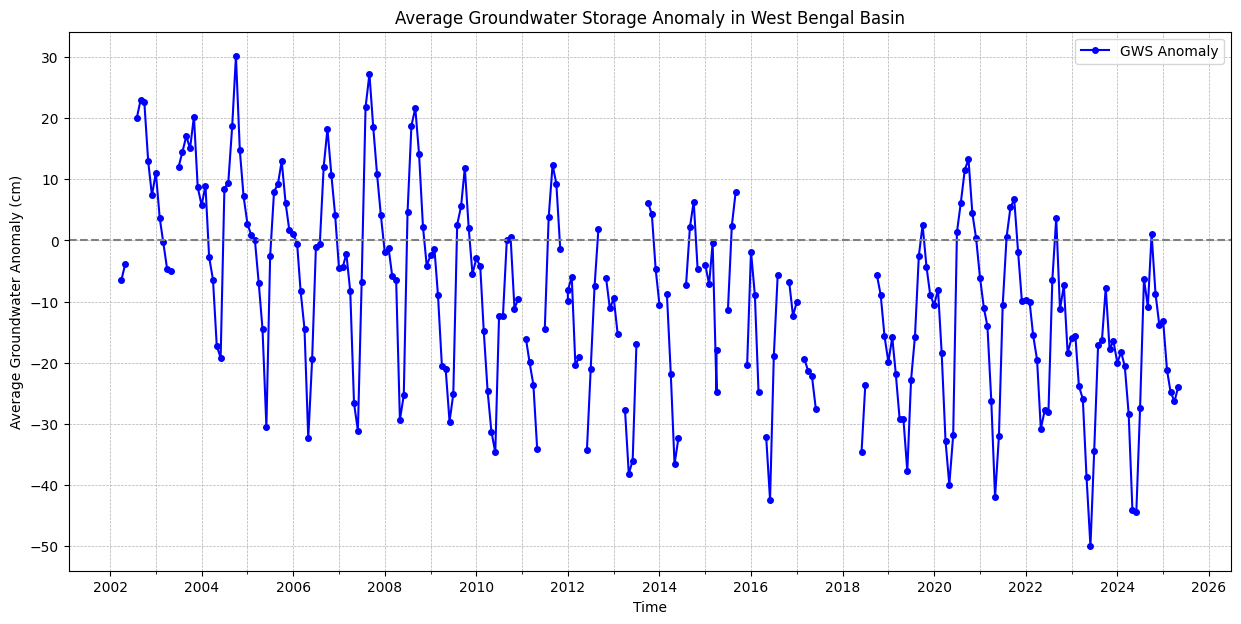

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Steps 1-4: Load and prepare the data (these are unchanged) ---
final_df = pd.read_csv('NOAH_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

gws_basin_avg = final_df.groupby('time')['GWS_anomaly_cm'].mean().reset_index()

gws_basin_avg['time'] = gws_basin_avg['time'].dt.to_period('M').dt.start_time

full_date_range = pd.date_range(
    start=gws_basin_avg['time'].min(), 
    end=gws_basin_avg['time'].max(), 
    freq='MS'
)
full_date_df = pd.DataFrame({'time': full_date_range})

plot_df = pd.merge(full_date_df, gws_basin_avg, on='time', how='left')


# --- Step 5: Create the plot ---
print("Generating the final connected time-series plot with data gaps...")

plt.figure(figsize=(15, 7))
ax = plt.gca()

# --- THE FIX: Use plt.plot() to draw a connected line ---
# This will automatically create breaks for the NaN values (missing months).
# The 'marker' adds a dot for each available month.
ax.plot(
    plot_df['time'], 
    plot_df['GWS_anomaly_cm'], 
    color='blue', 
    marker='o',          # Adds a circle at each data point
    linestyle='-',       # Connects the points with a solid line
    markersize=4,        # Makes the dots a bit smaller
    label='GWS Anomaly'
)

# Add a baseline and formatting
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_title('Average Groundwater Storage Anomaly in West Bengal Basin')
ax.set_xlabel('Time')
ax.set_ylabel('Average Groundwater Anomaly (cm)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Generating the final discontinuous smooth curve plot...


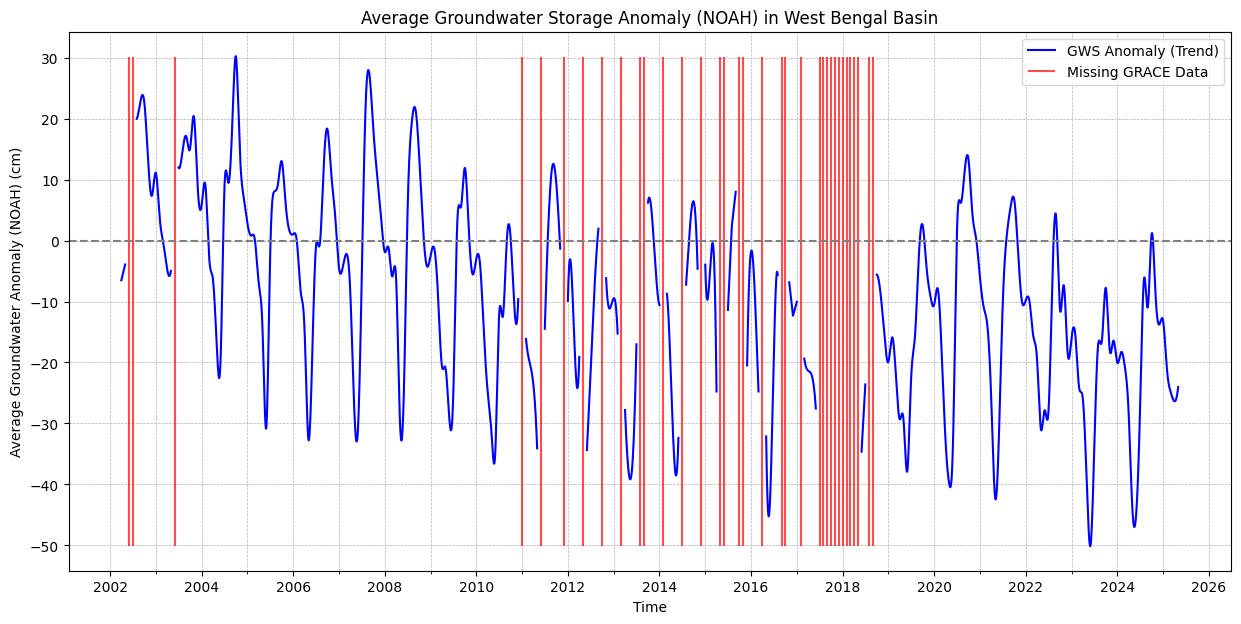

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import CubicSpline

# --- Steps 1-4: Load and prepare the data (these are unchanged) ---
final_df = pd.read_csv('NOAH_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

gws_basin_avg = final_df.groupby('time')['GWS_anomaly_cm'].mean().reset_index()

gws_basin_avg['time'] = gws_basin_avg['time'].dt.to_period('M').dt.start_time

full_date_range = pd.date_range(
    start=gws_basin_avg['time'].min(),
    end=gws_basin_avg['time'].max(),
    freq='MS'
)
full_date_df = pd.DataFrame({'time': full_date_range})

plot_df = pd.merge(full_date_df, gws_basin_avg, on='time', how='left')


# --- Step 5: Create the discontinuous smooth curve plot ---
print("Generating the final discontinuous smooth curve plot...")

plt.figure(figsize=(15, 7))
ax = plt.gca()

# Separate data into points that exist and points that are missing
has_data = plot_df.dropna().sort_values(by='time').drop_duplicates(subset='time')
missing_data = plot_df[plot_df['GWS_anomaly_cm'].isna()]

# --- THE FIX: Identify contiguous blocks of data ---
# A new block is identified where the gap between dates is more than a month
has_data['block'] = (has_data['time'].diff() > pd.Timedelta('32 days')).cumsum()

# Loop through each block and plot it as a separate smooth curve
for block_id, group in has_data.groupby('block'):
    # Spline interpolation needs at least a few points to work
    if len(group) > 3:
        # Convert dates to a numerical format for interpolation
        x_numeric = group['time'].astype(np.int64) // 10**9
        y = group['GWS_anomaly_cm']
        
        spline = CubicSpline(x_numeric, y)
        
        x_numeric_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 100 * len(group))
        x_datetime_smooth = pd.to_datetime(x_numeric_smooth, unit='s')
        
        y_smooth = spline(x_numeric_smooth)
        
        # Use the same color for all segments, but don't repeat the label
        ax.plot(x_datetime_smooth, y_smooth, color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly (Trend)')
    elif len(group) > 1: # If too few points for a spline, draw a straight line
        ax.plot(group['time'], group['GWS_anomaly_cm'], color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly (Trend)')

# --- Plot the missing data as red vertical lines ---
if not missing_data.empty:
    data_min = has_data['GWS_anomaly_cm'].min()
    data_max = has_data['GWS_anomaly_cm'].max()
    ax.vlines(
        missing_data['time'],
        ymin=data_min if pd.notna(data_min) else -1,
        ymax=data_max if pd.notna(data_max) else 1,
        color='red',
        linestyle='-',
        linewidth=1.5,
        alpha=0.7,
        label='Missing GRACE Data'
    )

# Add a baseline and formatting
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_title('Average Groundwater Storage Anomaly (NOAH) in West Bengal Basin')
ax.set_xlabel('Time')
ax.set_ylabel('Average Groundwater Anomaly (NOAH) (cm)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Generating the final time-series plot...


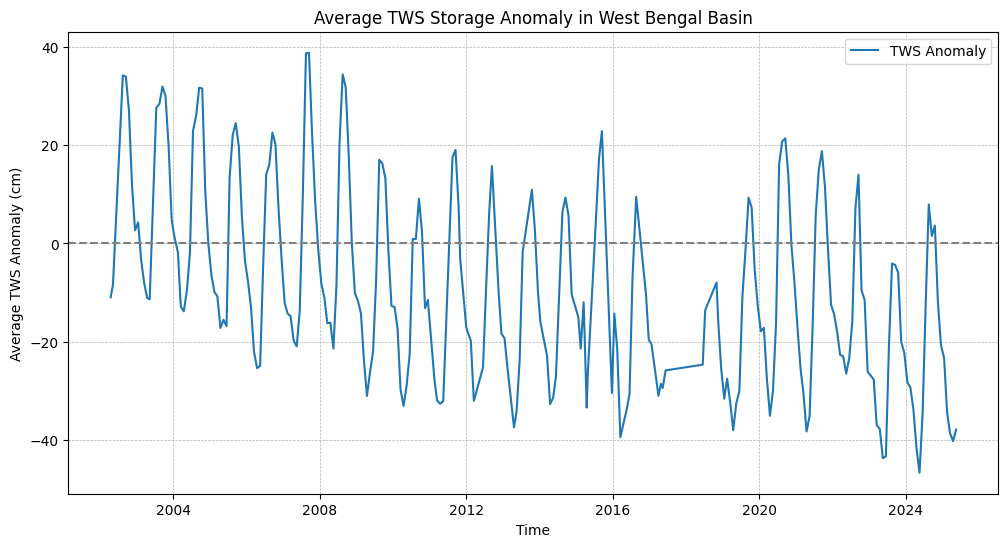

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your final file with the per-pixel GWS data (in cm) ---
# THE FIX: Load the correct cm-based file
final_df = pd.read_csv('NOAH_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Select the necessary columns ---
# THE FIX: Use the correct cm-based column name
gws_timeseries = final_df[['time', 'lwe_thickness_cm']].copy()

# --- Step 3: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = gws_timeseries.groupby('time').mean().reset_index()

# --- Step 4: Create the plot ---
print("Generating the final time-series plot...")

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plotting the data
# THE FIX: Use the correct cm-based column name
plt.plot('time', 'lwe_thickness_cm', data=gws_basin_avg, label='TWS Anomaly')

# Plotting a horizontal line at y=0 to serve as a baseline
plt.axhline(y=0, color='gray', linestyle='--')

# Adding a title and labels
plt.title('Average TWS Storage Anomaly in West Bengal Basin')
plt.xlabel('Time')
# THE FIX: Update the y-axis label to 'cm'
plt.ylabel('Average TWS Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Displaying the plot
plt.show()

Loading data to create a map for 2021-10...
Synchronizing and clipping data...
Generating map...


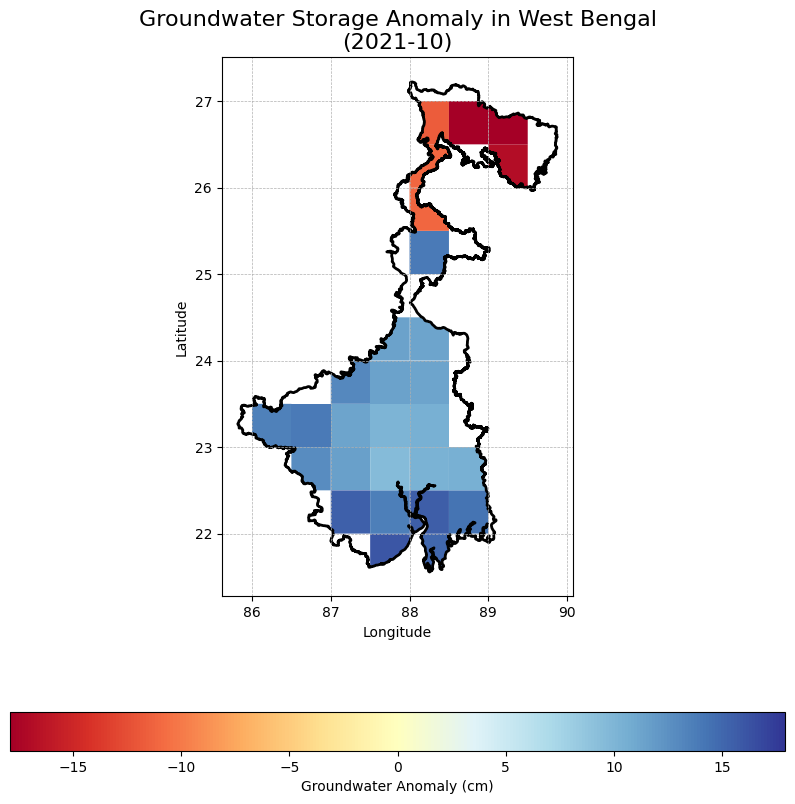

In [29]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## --- Configuration ---
year_to_plot = 2021
month_to_plot = 10  

# --- File paths ---
# THE FIX: Load the correct cm-based file
gws_file = 'NOAH_GWS_Final_Results_per_Pixel_cm.csv'
shapefile_path = r'D:\Groundwater Vulnerability Mapping\data\shapefiles\West Bengal\West_Bengal.shp'

## --- Step 1: Load Data ---
print(f"Loading data to create a map for {year_to_plot}-{month_to_plot:02d}...")
final_df = pd.read_csv(gws_file)
final_df['time'] = pd.to_datetime(final_df['time'])
basin_shapefile = gpd.read_file(shapefile_path)

## --- Step 2: Filter by Year and Month ---
mask = (final_df['time'].dt.year == year_to_plot) & (final_df['time'].dt.month == month_to_plot)
gws_for_date = final_df[mask].copy()

if gws_for_date.empty:
    print(f"Error: No data found for {year_to_plot}-{month_to_plot:02d}.")
else:
    ## --- Step 3: Prepare Spatial Data (for 0.5° grid) ---
    geometries = []
    for index, row in gws_for_date.iterrows():
        lon, lat = row['lon'], row['lat']
        # Create 0.5 degree polygons
        lon_point_list = [lon - 0.25, lon + 0.25, lon + 0.25, lon - 0.25, lon - 0.25]
        lat_point_list = [lat - 0.25, lat - 0.25, lat + 0.25, lat + 0.25, lat - 0.25]
        geometries.append(Polygon(zip(lon_point_list, lat_point_list)))

    gws_gdf = gpd.GeoDataFrame(gws_for_date, geometry=geometries, crs="EPSG:4326")

    ## --- Step 4: Clip the Data Grid to the Shapefile ---
    print("Synchronizing and clipping data...")
    basin_shapefile = basin_shapefile.to_crs(gws_gdf.crs)
    gws_clipped = gpd.clip(gws_gdf, basin_shapefile)

    ## --- Step 5: Create the Final Map ---
    if gws_clipped.empty:
        print("Error: The clipped dataset is empty.")
    else:
        print("Generating map...")

        # THE FIX: Use the correct cm-based column name
        v_abs = gws_clipped['GWS_anomaly_cm'].abs().quantile(0.95)
        vmin, vmax = -v_abs, v_abs

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        gws_clipped.plot(column='GWS_anomaly_cm', # THE FIX: Plot the correct cm-based column
                         ax=ax, 
                         legend=True,
                         # THE FIX: Update the legend label to 'cm'
                         legend_kwds={'label': "Groundwater Anomaly (cm)", 'orientation': "horizontal"},
                         cmap='RdYlBu', # Standard: Red=Dry, Blue=Wet
                         vmin=vmin,
                         vmax=vmax)

        basin_shapefile.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

        ax.set_title(f'Groundwater Storage Anomaly in West Bengal\n({year_to_plot}-{month_to_plot:02d})', fontsize=16)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, linestyle='--', linewidth=0.5)

        plt.show()

In [30]:
import pandas as pd

# --- Step 1: Load and CLEAN the data ---
gappy_df = pd.read_csv('NOAH_GWS_Final_Results_per_Pixel_cm.csv')
gappy_df['time'] = pd.to_datetime(gappy_df['time'])

# --- THE FIX: Standardize the time column FIRST ---
gappy_df['time'] = gappy_df['time'].dt.to_period('M').dt.start_time

# --- THEN, remove duplicates on the now-clean keys ---
gappy_df.drop_duplicates(subset=['time', 'lat', 'lon'], inplace=True)


# --- Step 2: Prepare the components for the master grid ---
full_date_range = pd.date_range(
    start=gappy_df['time'].min(), 
    end=gappy_df['time'].max(), 
    freq='MS'
)
full_date_df = pd.DataFrame({'time': full_date_range})

unique_pixels = gappy_df[['lat', 'lon']].drop_duplicates()

# --- Step 3: Build the complete master grid (scaffold) ---
unique_pixels['key'] = 1
full_date_df['key'] = 1
scaffold_df = pd.merge(full_date_df, unique_pixels, on='key').drop('key', axis=1)

# --- Step 4: Merge the gappy data onto the full grid ---
final_gap_filled_df = pd.merge(scaffold_df, gappy_df, on=['time', 'lat', 'lon'], how='left')

# --- Step 5: Save the new, gap-filled file ---
output_filename = 'GWS_All_Pixels_All_Vars_Gap_Filled.csv'
final_gap_filled_df.to_csv(output_filename, index=False)

print(f"✅ Successfully created '{output_filename}' with the corrected order of operations.")

✅ Successfully created 'GWS_All_Pixels_All_Vars_Gap_Filled.csv' with the corrected order of operations.


In [102]:
import pandas as pd

# Allow pandas to display all rows without collapsing
pd.set_option('display.max_rows', None)

# Allow pandas to display all columns without collapsing
pd.set_option('display.max_columns', None)

# --- Step 1: Load your final, gap-filled master file ---
filename = 'GWS_All_Pixels_All_Vars_Gap_Filled.csv'
print(f"Loading data from '{filename}'...")
try:
    final_df = pd.read_csv(filename)
    final_df['time'] = pd.to_datetime(final_df['time'])
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: The file '{filename}' was not found. Please make sure it's in the correct directory.")
    exit()

# --- Step 2: Create a loop to ask for user input ---
while True:
    try:
        # Get year and month from the user
        year_to_check = int(input("\nEnter the YEAR you want to check (e.g., 2010): "))
        month_to_check = int(input("Enter the MONTH you want to check (e.g., 6 for June): "))

        # Filter the DataFrame for the specified year and month
        monthly_data = final_df[
            (final_df['time'].dt.year == year_to_check) & 
            (final_df['time'].dt.month == month_to_check)
        ]

        # --- Step 3: Display the results ---
        if not monthly_data.empty:
            print(f"\n--- Displaying Data for {year_to_check}-{month_to_check:02d} ---")
            # .to_string() ensures all columns are shown without being cut off
            print(monthly_data.to_string())
        else:
            print(f"\nNo data found for {year_to_check}-{month_to_check:02d}. This is likely a missing GRACE month.")

    except ValueError:
        print("\nInvalid input. Please enter numbers only for the year and month.")
    
    # Ask the user if they want to continue
    another = input("\nDo you want to check another date? (yes/no): ").lower()
    if another != 'yes':
        break

print("\nExiting the data checker.")

Loading data from 'GWS_All_Pixels_All_Vars_Gap_Filled.csv'...
Data loaded successfully.



--- Displaying Data for 2018-09 ---
           time    lat    lon  lwe_thickness_cm  uncertainty_cm  scale_factor  TotalSoilMoisture_kg/m2  SWE_inst_kg/m2  Qs_acc_kg/m2  TotalSoilMoisture_cm  SWE_cm  Qs_acc_cm  TotalSoilMoisture_mean_cm  SWE_mean_cm  Qs_acc_mean_cm  TotalSoilMoisture_anomaly_cm  SWE_anomaly_cm  Qs_acc_anomaly_cm  GWS_anomaly_cm
5713 2018-09-01  23.25  86.25               NaN             NaN           NaN                      NaN             NaN           NaN                   NaN     NaN        NaN                        NaN          NaN             NaN                           NaN             NaN                NaN             NaN
5714 2018-09-01  23.25  87.75               NaN             NaN           NaN                      NaN             NaN           NaN                   NaN     NaN        NaN                        NaN          NaN             NaN                           NaN             NaN                NaN             NaN
5715 2018-09-01  23.75  87.75 

--- Plotting data from: GWS_All_Pixels_All_Vars_Gap_Filled.csv ---
✅ File loaded successfully.
✅ Basin-wide average calculated.
Generating plot...


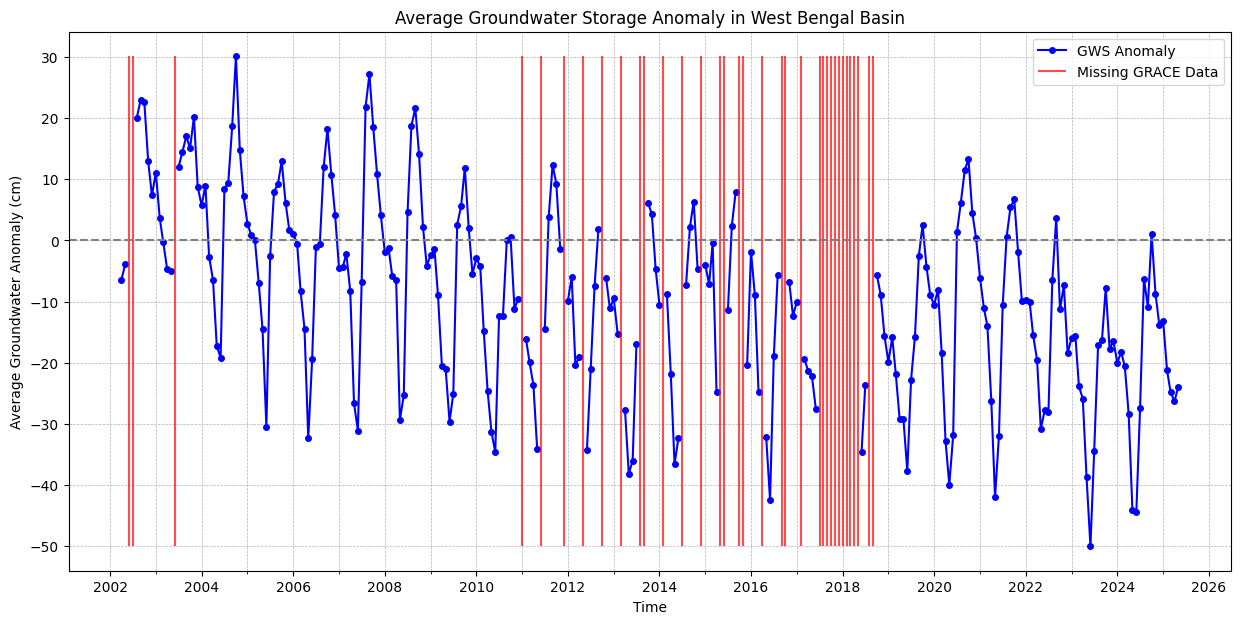

✅ Plot generated successfully.


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Configuration ---
filename_to_plot = 'GWS_All_Pixels_All_Vars_Gap_Filled.csv'
variable_to_plot = 'GWS_anomaly_cm'

print(f"--- Plotting data from: {filename_to_plot} ---")

try:
    # Load the dataset
    df = pd.read_csv(filename_to_plot)
    df['time'] = pd.to_datetime(df['time'])
    print("✅ File loaded successfully.")

    # --- Step 1: Aggregate data to a basin-wide average ---
    # The file is already gap-filled, so we just need to average the pixels for each month
    basin_avg = df.groupby('time')[variable_to_plot].mean().reset_index()
    print("✅ Basin-wide average calculated.")

    # --- Step 2: Create the plot ---
    print("Generating plot...")
    plt.figure(figsize=(15, 7))
    ax = plt.gca()

    # Plot the available data as a connected line with markers
    # The plot function will automatically create breaks where the data is NaN
    ax.plot(
        basin_avg['time'],
        basin_avg[variable_to_plot],
        color='blue',
        marker='o',
        linestyle='-',
        markersize=4,
        label='GWS Anomaly'
    )

    # Find the missing data periods to draw the red lines
    missing_data = basin_avg[basin_avg[variable_to_plot].isna()]
    if not missing_data.empty:
        # Determine the y-range for the vertical lines for better visuals
        data_min = basin_avg[variable_to_plot].min()
        data_max = basin_avg[variable_to_plot].max()
        ax.vlines(
            missing_data['time'],
            ymin=data_min,
            ymax=data_max,
            color='red',
            linestyle='-',
            linewidth=1.5,
            alpha=0.7,
            label='Missing GRACE Data'
        )
    
    # --- Step 3: Add formatting and display the plot ---
    ax.axhline(y=0, color='gray', linestyle='--')
    ax.set_title('Average Groundwater Storage Anomaly in West Bengal Basin')
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Groundwater Anomaly (cm)')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()

    # Improve date formatting on the x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.show()
    print("✅ Plot generated successfully.")

except FileNotFoundError:
    print(f"❌ ERROR: The file '{filename_to_plot}' was not found.")
except KeyError:
    print(f"❌ ERROR: The column '{variable_to_plot}' was not found in the file.")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")